In [1]:
import pandas as pd
import numpy as np 
import torch
import os
from itertools import chain
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
import pyro
import pyro.distributions as dist
from pyro.infer import config_enumerate, SVI, TraceEnum_ELBO
from pyro.ops.indexing import Vindex
from pyro.optim import ClippedAdam
from pyro.distributions import constraints
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

Using device: cuda


In [2]:
import random
import torch
from torch.nn.utils.rnn import pad_sequence

# Set reproducibility
random.seed(42)
torch.manual_seed(42)

# --- Diagnosis and context dictionaries ---
diag_dict = {
    0: ["DZ356", "DZ357", "DZ358"],  # Pregnant women
    1: ["DH33", "DH34", "DH35"],  # Hearing issues
    2: ["DC38", "DC380", "DC380A"]  # Lung disease
}

context_dict = {
    0: ["Gender_Kvinde", "AgeGroup_04", "Civilstatus_Gift"],         # Women, 25–35, married
    1: ["Gender_Mand", "AgeGroup_09", "Civilstatus_Gift"],           # Men, 75–85, married
    2: ["Gender_Mand", "AgeGroup_06", "Civilstatus_Ugift"]           # Men, 45–55, single
}

# --- Create vocabularies from tokens ---
all_diag_tokens = sorted(set(token for group in diag_dict.values() for token in group))
all_context_tokens = sorted(set(token for group in context_dict.values() for token in group))

diag_vocab = {token: idx for idx, token in enumerate(all_diag_tokens)}
context_vocab = {token: idx for idx, token in enumerate(all_context_tokens)}

# --- Sampling function ---
def sample_patient_data(num_patients_per_topic=10000):
    x_records = []
    d_records = []

    for topic_id in range(3):
        for _ in range(num_patients_per_topic):
            # Sample diagnoses (2 to 4 from the group's list)
            diag_sample = random.choices(diag_dict[topic_id], k=random.randint(2, 4))

            # Sample context
            if topic_id == 2:
                # 50/50 gender for group 2
                gender = random.choice(["Gender_Mand", "Gender_Kvinde"])
                context_sample = [gender, "AgeGroup_06", "Civilstatus_Ugift"]
            else:
                context_sample = context_dict[topic_id]

            # Convert to indices
            x_records.append(torch.tensor([diag_vocab[d] for d in diag_sample]))
            d_records.append(torch.tensor([context_vocab[c] for c in context_sample]))

    return x_records, d_records

# --- Padding and mask ---
def pad_and_mask(sequences):
    padded = pad_sequence(sequences, batch_first=True)
    mask = padded != 0
    return padded, mask

# --- Generate data ---
x_indexed, d_indexed = sample_patient_data(num_patients_per_topic=100)
x_tokens, x_mask = pad_and_mask(x_indexed)
d_tokens, d_mask = pad_and_mask(d_indexed)

total_patients = x_tokens.shape[0]



indices = torch.arange(total_patients)  # patient index tensor
dataset = TensorDataset(x_tokens, d_tokens, x_mask, d_mask, indices)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True, drop_last=True)


In [3]:
# Inverse vocab lookup
inv_diag_vocab = {v: k for k, v in diag_vocab.items()}
inv_context_vocab = {v: k for k, v in context_vocab.items()}

# Convert indexed tensors back to readable tokens
records = []
for i, (x, d) in enumerate(zip(x_indexed, d_indexed)):
    diagnoses = [inv_diag_vocab[token.item()] for token in x]
    context = [inv_context_vocab[token.item()] for token in d]
    records.append({
        "patient_id": i,
        "diagnoses": ", ".join(diagnoses),
        "context": ", ".join(context)
    })

# Create DataFrame
df_inspect = pd.DataFrame(records)

# Show the first few rows
print(df_inspect.head(10))  # or use df_inspect.sample(10) for random samples

   patient_id                   diagnoses  \
0           0  DZ356, DZ358, DZ356, DZ356   
1           1                DZ358, DZ358   
2           2                DZ357, DZ356   
3           3                DZ356, DZ357   
4           4                DZ357, DZ358   
5           5  DZ357, DZ356, DZ357, DZ358   
6           6                DZ358, DZ356   
7           7         DZ357, DZ356, DZ358   
8           8         DZ356, DZ357, DZ357   
9           9         DZ357, DZ358, DZ358   

                                        context  
0  Gender_Kvinde, AgeGroup_04, Civilstatus_Gift  
1  Gender_Kvinde, AgeGroup_04, Civilstatus_Gift  
2  Gender_Kvinde, AgeGroup_04, Civilstatus_Gift  
3  Gender_Kvinde, AgeGroup_04, Civilstatus_Gift  
4  Gender_Kvinde, AgeGroup_04, Civilstatus_Gift  
5  Gender_Kvinde, AgeGroup_04, Civilstatus_Gift  
6  Gender_Kvinde, AgeGroup_04, Civilstatus_Gift  
7  Gender_Kvinde, AgeGroup_04, Civilstatus_Gift  
8  Gender_Kvinde, AgeGroup_04, Civilstatus_Gift  
9  G

In [4]:
@config_enumerate(default="parallel")
def model(x_tokens, d_tokens, x_mask, d_mask,
          num_groups, num_diag_tokens, num_demo_tokens,
          device,patient_indices=None):

    
    x_tokens = x_tokens.to(device)
    d_tokens = d_tokens.to(device)
    x_mask = x_mask.to(device)
    d_mask = d_mask.to(device)
    patient_indices = patient_indices.to(device) if patient_indices is not None else None

    B, Nx = x_tokens.shape
    _, Nd = d_tokens.shape

    # prior parameters
    alpha = torch.ones(num_groups, device=device)  
    beta_x = torch.ones(num_diag_tokens, device=device) / num_diag_tokens
    beta_d = 0.1 * torch.ones(num_demo_tokens, device=device) / num_demo_tokens

    
    # Topic-word distributions (ϕ)
    with pyro.plate("health_groups", num_groups):
        phi_x = pyro.sample("phi_x", dist.Dirichlet(beta_x))
        phi_d = pyro.sample("phi_d", dist.Dirichlet(beta_d))

    # Per-patient topic proportions (θ)
    with pyro.plate("patients", B):
        theta = pyro.sample("theta", dist.Dirichlet(alpha))  # [B, K]

        # DIAGNOSIS TOKENS
        with pyro.plate("x_tokens", Nx):
            z_x = pyro.sample("z_x", dist.Categorical(theta))  # [B, Nx]
            with pyro.poutine.mask(mask=x_mask.permute(1, 0)):  # [Nx, B]
                probs_x = Vindex(phi_x)[z_x]  # [B, Nx, Vx]
                pyro.sample("w_x", dist.Categorical(probs=probs_x), obs=x_tokens.permute(1, 0))  # [Nx, B]

        # DEMOGRAPHIC TOKENS
        with pyro.plate("d_tokens", Nd):
            z_d = pyro.sample("z_d", dist.Categorical(theta))  # [B, Nd]
            with pyro.poutine.mask(mask=d_mask.permute(1, 0)):  # [Nd, B]
                probs_d = Vindex(phi_d)[z_d]  # [B, Nd, Vd]
                pyro.sample("w_d", dist.Categorical(probs=probs_d), obs=d_tokens.permute(1, 0))  # [Nd, B]



In [5]:
def guide(x_tokens, d_tokens, x_mask, d_mask,
          num_groups, num_diag_tokens, num_demo_tokens,
          device, patient_indices=None):

    x_tokens = x_tokens.to(device)
    d_tokens = d_tokens.to(device)
    x_mask = x_mask.to(device)
    d_mask = d_mask.to(device)
    patient_indices = patient_indices.to(device) if patient_indices is not None else None

    B = x_tokens.shape[0]

    # --- Global topic-word distributions ---
    phi_x_posterior = pyro.param("phi_x_posterior",
                                 torch.ones(num_groups, num_diag_tokens, device=device),
                                 constraint=constraints.simplex)
    phi_d_posterior = pyro.param("phi_d_posterior",
                                 torch.ones(num_groups, num_demo_tokens, device=device),
                                 constraint=constraints.simplex)

    with pyro.plate("health_groups", num_groups):
        pyro.sample("phi_x", dist.Dirichlet(phi_x_posterior))
        pyro.sample("phi_d", dist.Dirichlet(phi_d_posterior))

    # --- Global per-patient variational parameters ---
    full_theta_param = pyro.param("full_theta_param",
                                  0.3 * torch.ones(total_patients, num_groups, device=device),
                                  constraint=constraints.positive)

    if patient_indices is None:
        raise ValueError("patient_indices must be provided for per-patient variational parameters.")

    selected_theta = full_theta_param.index_select(0, patient_indices)

    with pyro.plate("patients", B):
        pyro.sample("theta", dist.Dirichlet(selected_theta))



In [6]:
pyro.clear_param_store()

optimizer = ClippedAdam({"lr": 1e-4})
svi = SVI(model, guide, optimizer, loss=TraceEnum_ELBO(max_plate_nesting=2))


num_groups = 3
num_diag_tokens = len(diag_vocab)
num_demo_tokens = len(context_vocab)
num_steps = 100
losses = []

# Training loop with minibatching
for step in range(num_steps):
    total_loss = 0
    for x_batch, d_batch, x_mask, d_mask, idx_batch in dataloader:

        x_batch = x_batch.to(device)
        d_batch = d_batch.to(device)
        x_mask = x_mask.to(device)
        d_mask = d_mask.to(device)
        idx_batch = idx_batch.to(device)

        loss = svi.step(x_batch, d_batch, x_mask, d_mask,
                    num_groups, num_diag_tokens, num_demo_tokens,
                    device, patient_indices=idx_batch)

        total_loss += loss

    print(f"[Step {step}] ELBO Loss: {total_loss:.2f}")
gc.collect()
torch.cuda.empty_cache()

[Step 0] ELBO Loss: 7983.53
[Step 1] ELBO Loss: 8321.04
[Step 2] ELBO Loss: 8237.70
[Step 3] ELBO Loss: 7783.36
[Step 4] ELBO Loss: 7950.70
[Step 5] ELBO Loss: 8041.93
[Step 6] ELBO Loss: 7987.80
[Step 7] ELBO Loss: 8203.25


KeyboardInterrupt: 

In [34]:
# right after you build `dataset = TensorDataset(...)`:
total_patients = len(dataset)

# -------------------------------------------------------------------
# MODEL
# -------------------------------------------------------------------
@config_enumerate(default="parallel")
def model(x_tokens, d_tokens, x_mask, d_mask,
          num_groups, num_diag_tokens, num_demo_tokens,
          device, patient_indices=None):

    x_tokens, d_tokens = x_tokens.to(device),   d_tokens.to(device)
    x_mask,   d_mask   = x_mask.to(device),     d_mask.to(device)
    B, Nx = x_tokens.shape
    _, Nd = d_tokens.shape

    # 1) Priors: neutral/topic‐symmetric
    alpha  = torch.ones(num_groups, device=device)            # Dir(1)
    beta_x = torch.ones(num_diag_tokens, device=device)       # uniform Dir
    beta_d = torch.ones(num_demo_tokens, device=device)       # uniform Dir

    # 2) Topic‐word distributions
    with pyro.plate("health_groups", num_groups):
        phi_x = pyro.sample("phi_x", dist.Dirichlet(beta_x))
        phi_d = pyro.sample("phi_d", dist.Dirichlet(beta_d))

    # 3) Per‐patient topic mix
    with pyro.plate("patients", B):
        theta = pyro.sample("theta", dist.Dirichlet(alpha))  # [B, K]

        # diagnoses
        with pyro.plate("x_tokens", Nx):
            z_x = pyro.sample("z_x", dist.Categorical(theta))
            with pyro.poutine.mask(mask=x_mask.permute(1,0)):
                probs_x = Vindex(phi_x)[z_x]        # [B,Nx,Vx]
                pyro.sample("w_x",
                            dist.Categorical(probs=probs_x),
                            obs=x_tokens.permute(1,0))

        # demographics
        with pyro.plate("d_tokens", Nd):
            z_d = pyro.sample("z_d", dist.Categorical(theta))
            with pyro.poutine.mask(mask=d_mask.permute(1,0)):
                probs_d = Vindex(phi_d)[z_d]        # [B,Nd,Vd]
                pyro.sample("w_d",
                            dist.Categorical(probs=probs_d),
                            obs=d_tokens.permute(1,0))


# -------------------------------------------------------------------
# GUIDE
# -------------------------------------------------------------------
def guide(x_tokens, d_tokens, x_mask, d_mask,
          num_groups, num_diag_tokens, num_demo_tokens,
          device, patient_indices=None):

    x_tokens, d_tokens = x_tokens.to(device),   d_tokens.to(device)
    x_mask,   d_mask   = x_mask.to(device),     d_mask.to(device)
    if patient_indices is None:
        raise ValueError("you must pass patient_indices to guide")
    patient_indices = patient_indices.to(device)
    B = x_tokens.size(0)

    # 1) Global topic‐word variational posteriors
    init_phi_x = torch.full((num_groups, num_diag_tokens), 1.0, device=device)
    init_phi_d = torch.full((num_groups, num_demo_tokens),   1.0, device=device)
    phi_x_posterior = pyro.param("phi_x_posterior",
                                 init_phi_x + 0.01 * torch.randn_like(init_phi_x),
                                 constraint=constraints.simplex)
    phi_d_posterior = pyro.param("phi_d_posterior",
                                 init_phi_d + 0.01 * torch.randn_like(init_phi_d),
                                 constraint=constraints.simplex)

    with pyro.plate("health_groups", num_groups):
        pyro.sample("phi_x", dist.Dirichlet(phi_x_posterior))
        pyro.sample("phi_d", dist.Dirichlet(phi_d_posterior))

    # 2) Per‐patient posterior for θ
    full_theta_param = pyro.param("full_theta_param",
                                  torch.ones(total_patients, num_groups, device=device),
                                  constraint=constraints.positive)

    # select only the rows for this minibatch:
    theta_param_batch = full_theta_param.index_select(0, patient_indices)

    with pyro.plate("patients", B):
        pyro.sample("theta", dist.Dirichlet(theta_param_batch))


# -------------------------------------------------------------------
# SVI SETUP
# -------------------------------------------------------------------
pyro.clear_param_store()
optimizer = ClippedAdam({"lr": 1e-3})
svi = SVI(model, guide, optimizer, loss=TraceEnum_ELBO(max_plate_nesting=2))

# Training loop (unchanged)
num_steps = 500
for step in range(num_steps):
    total_loss = 0.0
    for x_b,d_b, xm,dm, idx in dataloader:
        total_loss += svi.step(x_b, d_b, xm, dm,
                               num_groups, num_diag_tokens, num_demo_tokens,
                               device, patient_indices=idx)
    if step % 50 == 0:
        print(f"Step {step} ELBO = {total_loss:.1f}")


Step 0 ELBO = 11255.5
Step 50 ELBO = 11506.6
Step 100 ELBO = 11712.8
Step 150 ELBO = 11570.0
Step 200 ELBO = 11536.4
Step 250 ELBO = 11900.2
Step 300 ELBO = 11166.8
Step 350 ELBO = 11688.4
Step 400 ELBO = 11650.6
Step 450 ELBO = 11809.9


θ posterior min: 1.1070454120635986 max: 1.5633035898208618


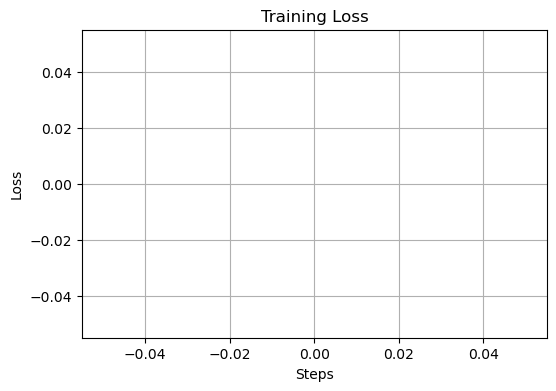

In [35]:
theta = pyro.param("full_theta_param").detach().cpu()
print("θ posterior min:", theta.min().item(), "max:", theta.max().item())

num_steps = len(losses)

# loss plotting
def plot_loss(losses):
    plt.figure(figsize=(6, 4))
    plt.plot(losses)
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    #plt.yscale("log")
    plt.grid()
    plt.show()


plot_loss(losses)

In [36]:
def plot_top_demographic_categories(phi_d, inv_context_vocab, topic_idx, title_prefix="Demographic Topic"):
    topic_dist = phi_d[topic_idx].detach().cpu()
    
   
    token_labels = [inv_context_vocab[i] for i in range(len(inv_context_vocab))]
    
    
    gender_tokens = [(label, prob) for label, prob in zip(token_labels, topic_dist) if "Gender_" in label]
    age_tokens = [(label, prob) for label, prob in zip(token_labels, topic_dist) if "AgeGroup_" in label]
    civil_tokens = [(label, prob) for label, prob in zip(token_labels, topic_dist) if "Civilstatus_" in label]

    
    top_gender = max(gender_tokens, key=lambda x: x[1]) if gender_tokens else ("None", 0.0)
    top_age = max(age_tokens, key=lambda x: x[1]) if age_tokens else ("None", 0.0)
    top_civil = max(civil_tokens, key=lambda x: x[1]) if civil_tokens else ("None", 0.0)

    labels = [top_gender[0], top_civil[0], top_age[0]]
    probs = [top_gender[1], top_civil[1], top_age[1]]

    
    plt.figure(figsize=(8, 4))
    plt.barh(labels[::-1], [p.item() for p in probs[::-1]])  
    plt.xlabel("Probability")
    plt.title(f"{title_prefix} {topic_idx} – Top Demographic Attributes")
    plt.tight_layout()
    plt.show()

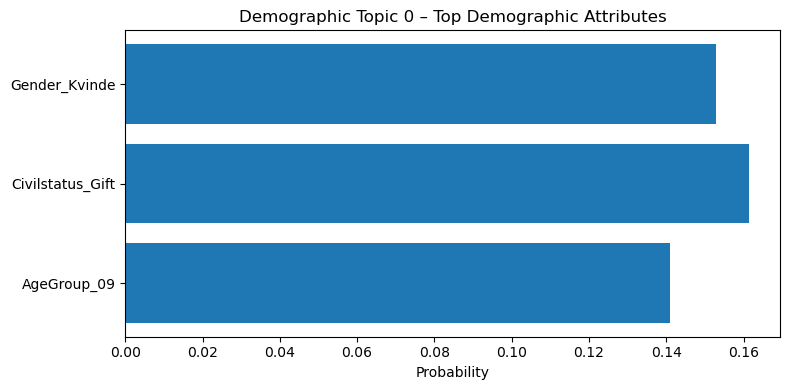

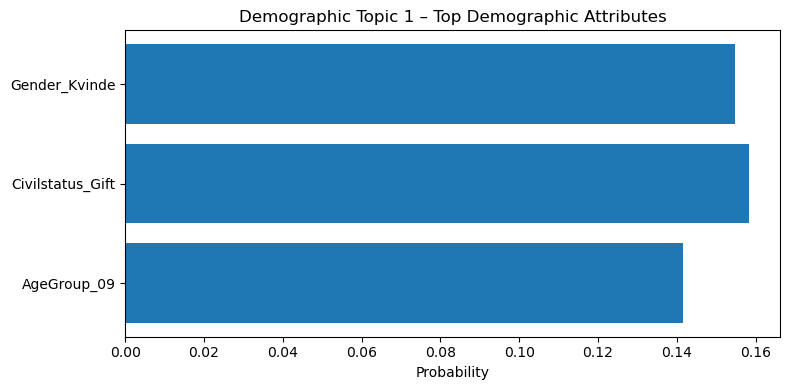

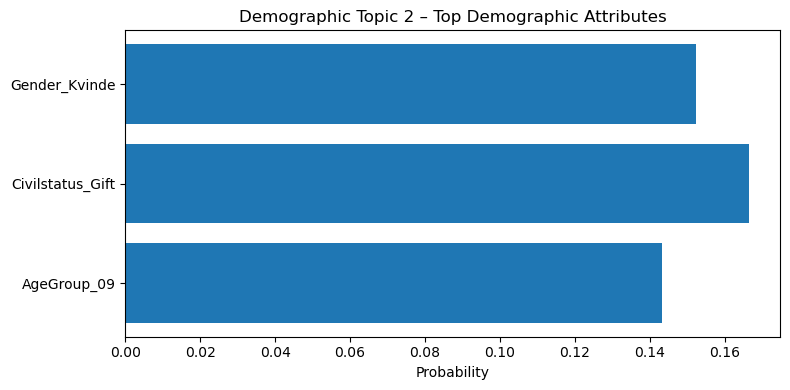

In [37]:
phi_x = pyro.get_param_store().get_param("phi_x_posterior")  
phi_d = pyro.get_param_store().get_param("phi_d_posterior")  


num_topics_to_plot =3
inv_context_vocab = {idx: token for token, idx in context_vocab.items()}
for i in range(num_topics_to_plot):
    plot_top_demographic_categories(phi_d, inv_context_vocab,i, title_prefix="Demographic Topic")

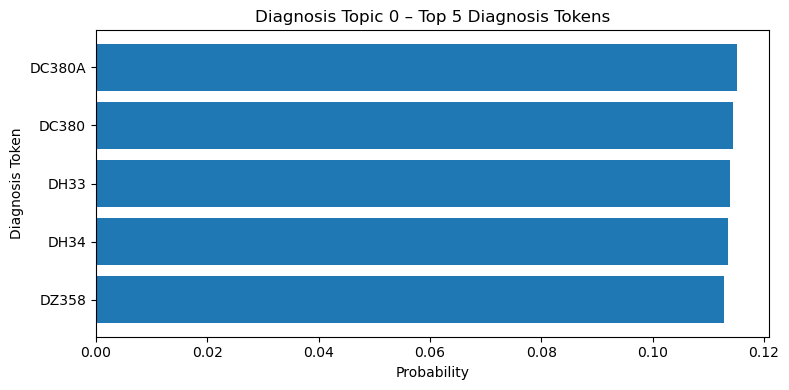

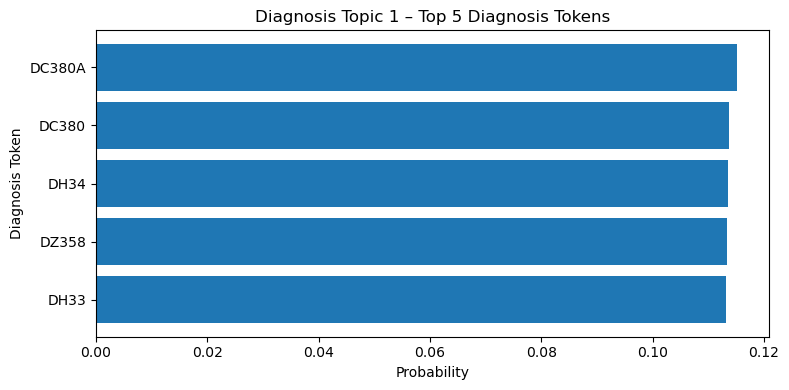

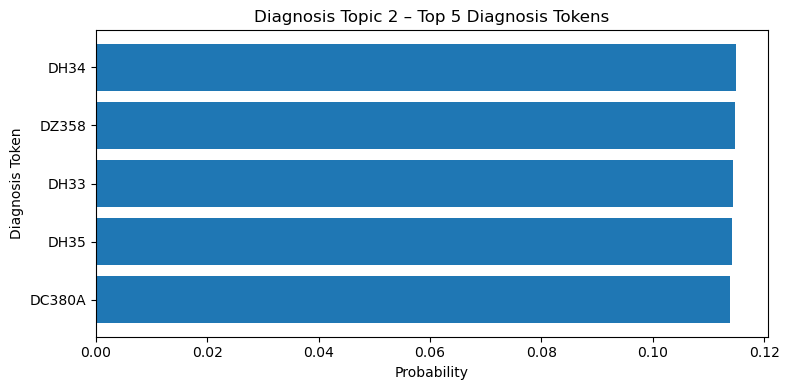

In [38]:
def plot_top_tokens(phi_matrix, vocab_inv, topic_idx, top_k=10, title_prefix="Topic", label="Token"):
    
    topic_dist = phi_matrix[topic_idx]  # [vocab_size]
    topk_indices = torch.topk(topic_dist, top_k).indices
    topk_tokens = [vocab_inv[i.item()] for i in topk_indices]
    topk_probs = topic_dist[topk_indices].detach().cpu().numpy()

    plt.figure(figsize=(8, 4))
    plt.barh(topk_tokens[::-1], topk_probs[::-1])
    plt.xlabel("Probability")
    plt.ylabel(label)
    plt.title(f"{title_prefix} {topic_idx} – Top {top_k} {label}s")
    plt.tight_layout()
    plt.show()
    

num_topics_to_plot = 3

inv_diag_vocab = {idx: token for token, idx in diag_vocab.items()}
for i in range(num_topics_to_plot):
    plot_top_tokens(phi_x, inv_diag_vocab, topic_idx=i, top_k=5,
                    title_prefix="Diagnosis Topic", label="Diagnosis Token")

In [32]:
import numpy as np

# Move tensors to CPU and convert to numpy
phi_x = pyro.param("phi_x_posterior").detach().cpu().numpy()
phi_d = pyro.param("phi_d_posterior").detach().cpu().numpy()

# Reverse vocab lookups
inv_diag_vocab = {idx: token for token, idx in diag_vocab.items()}
inv_context_vocab = {idx: token for token, idx in context_vocab.items()}

# Print top tokens per topic
print("\nLearned Topics:")
for k in range(phi_x.shape[0]):
    print(f"\n--- Topic {k} ---")

    top_diag_indices = np.argsort(phi_x[k])[::-1][:5]
    top_context_indices = np.argsort(phi_d[k])[::-1][:5]

    top_diags = [inv_diag_vocab[i] for i in top_diag_indices]
    top_context = [inv_context_vocab[i] for i in top_context_indices]

    print("Top Diagnoses:", top_diags)
    print("Top Context:", top_context)



Learned Topics:

--- Topic 0 ---
Top Diagnoses: ['DH33', 'DH34', 'DC380', 'DH35', 'DZ358']
Top Context: ['Civilstatus_Gift', 'Gender_Kvinde', 'Gender_Mand', 'AgeGroup_09', 'AgeGroup_06']

--- Topic 1 ---
Top Diagnoses: ['DH33', 'DC380', 'DC380A', 'DH34', 'DZ358']
Top Context: ['Civilstatus_Gift', 'Gender_Kvinde', 'Gender_Mand', 'AgeGroup_09', 'AgeGroup_06']

--- Topic 2 ---
Top Diagnoses: ['DH33', 'DH34', 'DC380', 'DC380A', 'DZ357']
Top Context: ['Civilstatus_Gift', 'Gender_Kvinde', 'Gender_Mand', 'AgeGroup_09', 'AgeGroup_06']


In [1]:
# first pip install gensim if you don’t have it:
#    pip install gensim

from gensim.corpora import Dictionary
from gensim.models import LdaModel

# --- build your “documents” as lists of tokens ---
# x_indexed and d_indexed are lists of torch tensors of diag/context indices,
# but you already built df_inspect with string tokens:

# suppose df_inspect has columns "diagnoses" and "context" as comma‐joined strings:
docs = []
for row in df_inspect.itertuples():
    diag_tokens    = row.diagnoses.split(", ")
    context_tokens = row.context.split(", ")
    docs.append(diag_tokens + context_tokens)

# --- gensim preprocessing ---
dictionary = Dictionary(docs)
corpus     = [dictionary.doc2bow(doc) for doc in docs]

# --- train a 3-topic LDA ---
lda = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=3,
    passes=50,       # a few passes over the data
    random_state=42,
)

# --- inspect each topic ---
for t in range(3):
    print(f"\n--- Topic {t} ---")
    for token, weight in lda.show_topic(t, topn=5):
        print(f"  {token:20s} {weight:.3f}")


ModuleNotFoundError: No module named 'gensim'